In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from pysheds.view import Raster
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# Instantiate grid

In [2]:
grid = Grid.from_raster("../data/n30w100_con", data_name="dem")

In [3]:
grid.read_raster("../data/n30w100_dir", data_name="dir")

In [4]:
# N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [5]:
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(
    data="dir",
    x=x,
    y=y,
    dirmap=dirmap,
    out_name="catch",
    recursionlimit=15000,
    xytype="label",
    nodata_out=0,
)

In [6]:
# Clip the bounding box to the catchment
grid.clip_to("catch")

# Compute accumulated angle

In [7]:
xcomp = np.asarray([0, 1 / np.sqrt(2), 1, 1 / np.sqrt(2), 0, -1 / np.sqrt(2), -1, -1 / np.sqrt(2)])

In [8]:
ycomp = np.asarray([1, 1 / np.sqrt(2), 0, -1 / np.sqrt(2), -1, -1 / np.sqrt(2), 0, 1 / np.sqrt(2)])

In [9]:
xweights = (
    pd.Series(grid.view("dir", apply_mask=False).ravel())
    .map(pd.Series(xcomp, index=dirmap))
    .fillna(0)
    .values
)
yweights = (
    pd.Series(grid.view("dir", apply_mask=False).ravel())
    .map(pd.Series(ycomp, index=dirmap))
    .fillna(0)
    .values
)

In [10]:
grid.accumulation(data="dir", dirmap=dirmap, nodata_in=0, out_name="acc")

In [11]:
grid.accumulation(data="dir", weights=xweights, dirmap=dirmap, nodata_in=0, out_name="xacc")

In [12]:
grid.accumulation(data="dir", weights=yweights, dirmap=dirmap, nodata_in=0, out_name="yacc")

In [13]:
acc_angle = np.arctan2(grid.view("yacc", dtype=np.float64), grid.view("xacc", dtype=np.float64))
acc_angle = np.where(grid.mask, acc_angle, np.nan)

# Compute reference angles

In [14]:
mapping = {
    64: np.pi / 2,
    128: np.pi / 4,
    1: 0,
    2: -np.pi / 4,
    4: -np.pi / 2,
    8: -3 * np.pi / 4,
    16: np.pi,
    32: 3 * np.pi / 4,
    255: np.nan,
}
s = pd.Series(grid.view("dir").ravel()).map(mapping)

# Compare accumulated angle and reference angles

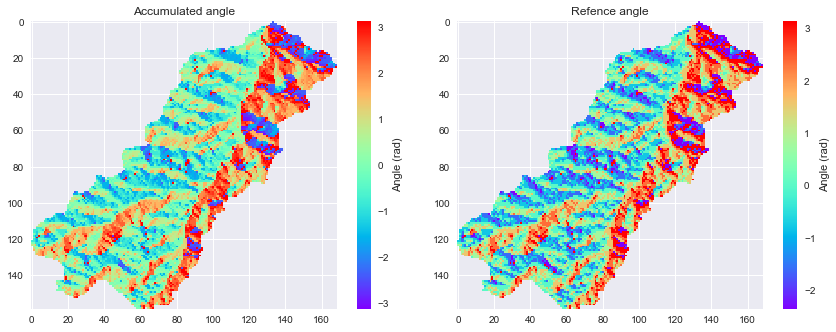

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
im0 = ax[0].imshow(acc_angle, zorder=1, cmap="rainbow")
im1 = ax[1].imshow(s.values.reshape(grid.shape), cmap="rainbow", zorder=1)
plt.colorbar(im0, ax=ax[0], label="Angle (rad)")
plt.colorbar(im1, ax=ax[1], label="Angle (rad)")
ax[0].set_title("Accumulated angle")
ax[1].set_title("Refence angle")
plt.tight_layout()

# Accumulated angle is good predictor of next flow direction

In [16]:
est = acc_angle.ravel()[~np.isnan(acc_angle.ravel())]
gt = s[~np.isnan(acc_angle.ravel())].values
acc = grid.view("acc").ravel()[~np.isnan(acc_angle.ravel())]

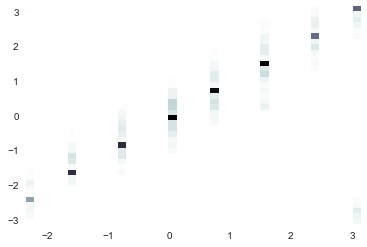

In [17]:
h = plt.hist2d(gt, est, bins=40, zorder=1, cmap="bone_r")

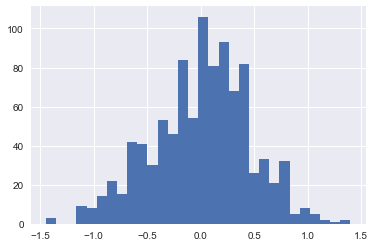

In [18]:
df = pd.DataFrame(np.column_stack([gt, est, acc]))
z = df[gt == 0]
z[z[2] > 3][1].hist(bins=30)